In [1]:
import pandas as pd

from IPython.display import clear_output

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

from sklearn.model_selection import GridSearchCV

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
columns_to_lbl = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn'] 

In [7]:
df_w = df
for col in columns_to_lbl:
    le = LabelEncoder()
    le.fit(df_w[col].unique())
    df_w[col] = le.transform(df_w[col])
df_w.TotalCharges.replace(' ', 0, inplace=True )
df_w.TotalCharges = df_w.TotalCharges.astype(float)
df_w.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [8]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int32  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int32  
 4   Dependents        7043 non-null   int32  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int32  
 7   MultipleLines     7043 non-null   int32  
 8   InternetService   7043 non-null   int32  
 9   OnlineSecurity    7043 non-null   int32  
 10  OnlineBackup      7043 non-null   int32  
 11  DeviceProtection  7043 non-null   int32  
 12  TechSupport       7043 non-null   int32  
 13  StreamingTV       7043 non-null   int32  
 14  StreamingMovies   7043 non-null   int32  
 15  Contract          7043 non-null   int32  
 16  PaperlessBilling  7043 non-null   int32  


In [9]:
df_w.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.940508,0.872923,0.790004,0.906432,0.904444,0.797104,0.985376,0.992475,0.690473,0.592219,1.574329,64.761692,2279.734304,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.948554,0.737796,0.859848,0.880162,0.879949,0.861551,0.885002,0.885091,0.833755,0.491457,1.068104,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.500000,398.550000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1394.550000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


In [10]:
df_w['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

array([[<AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'SeniorCitizen'}>,
        <AxesSubplot:title={'center':'Partner'}>,
        <AxesSubplot:title={'center':'Dependents'}>],
       [<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'PhoneService'}>,
        <AxesSubplot:title={'center':'MultipleLines'}>,
        <AxesSubplot:title={'center':'InternetService'}>],
       [<AxesSubplot:title={'center':'OnlineSecurity'}>,
        <AxesSubplot:title={'center':'OnlineBackup'}>,
        <AxesSubplot:title={'center':'DeviceProtection'}>,
        <AxesSubplot:title={'center':'TechSupport'}>],
       [<AxesSubplot:title={'center':'StreamingTV'}>,
        <AxesSubplot:title={'center':'StreamingMovies'}>,
        <AxesSubplot:title={'center':'Contract'}>,
        <AxesSubplot:title={'center':'PaperlessBilling'}>],
       [<AxesSubplot:title={'center':'PaymentMethod'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>,
        <A

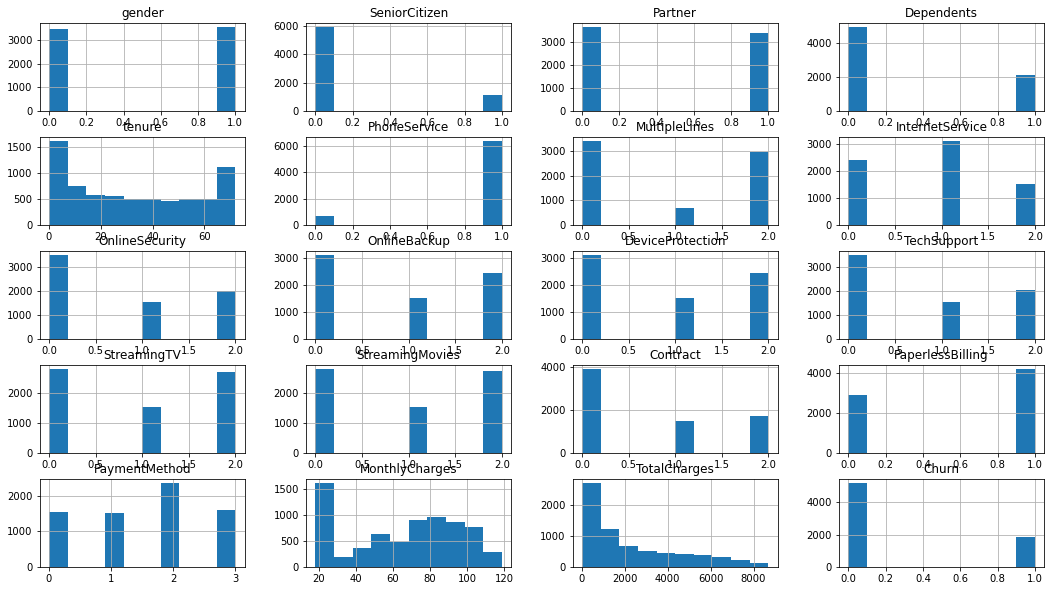

In [11]:
df_w.hist(figsize=(18, 10))

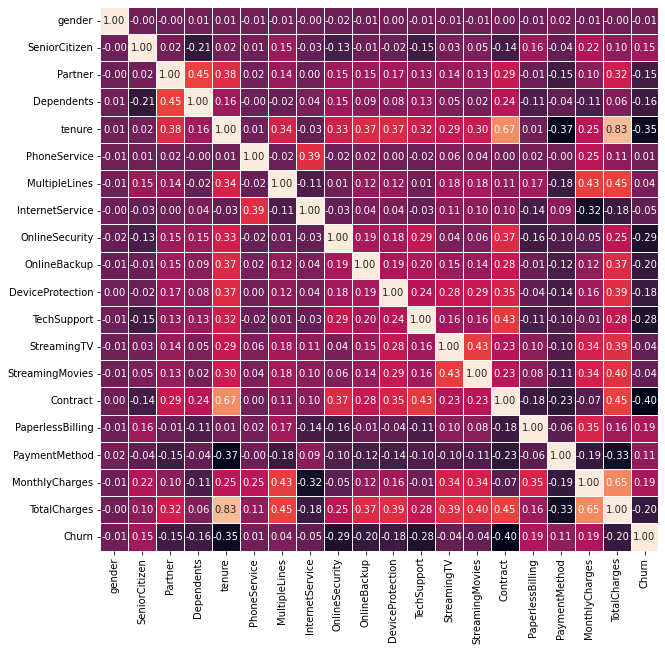

In [12]:
#correlation map
plt.figure(figsize=(10, 10))
sns.heatmap(df_w.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()
#del gender

In [13]:
to_drop = ['gender', 'PhoneService','MultipleLines', 'InternetService','StreamingTV', 'StreamingMovies']

In [14]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

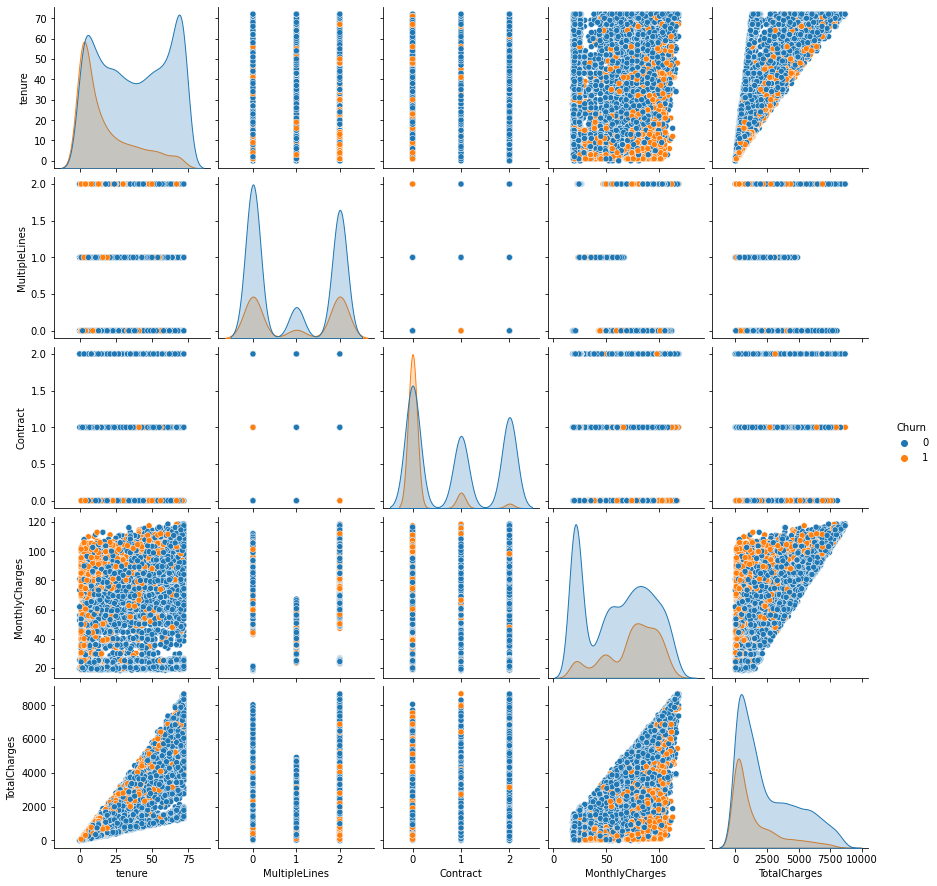

In [15]:
sns.pairplot(df_w[['tenure','MultipleLines', 'Contract', 'MonthlyCharges', 'TotalCharges','Churn']], hue='Churn')

# Разбиение на X и y

In [16]:
df_w_x = df_w.iloc[:,:-1]
df_w_x = df_w_x.drop(['customerID']+to_drop,axis = 1)
df_w_x

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,1,0,1,0,2,0,0,0,1,2,29.85,29.85
1,0,0,0,34,2,0,2,0,1,0,3,56.95,1889.50
2,0,0,0,2,2,2,0,0,0,1,3,53.85,108.15
3,0,0,0,45,2,0,2,2,1,0,0,42.30,1840.75
4,0,0,0,2,0,0,0,0,0,1,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24,2,0,2,2,1,1,3,84.80,1990.50
7039,0,1,1,72,0,2,2,0,1,1,1,103.20,7362.90
7040,0,1,1,11,2,0,0,0,0,1,2,29.60,346.45
7041,1,1,0,4,0,0,0,0,0,1,3,74.40,306.60


In [17]:
df_w_y = df_w.iloc[:,-1]
df_w_y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int32

## Понижение размерности 


In [18]:
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_w_x)
pca = PCA()
pca.fit(X_scaled)

PCA()

In [19]:
pca.explained_variance_ratio_

array([0.26523676, 0.14135637, 0.12090301, 0.07638583, 0.07339229,
       0.0664929 , 0.05936724, 0.05513968, 0.04500149, 0.04322459,
       0.03627827, 0.01519081, 0.00203075])

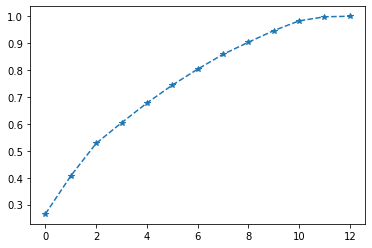

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), '*--');

In [21]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df_w_x)

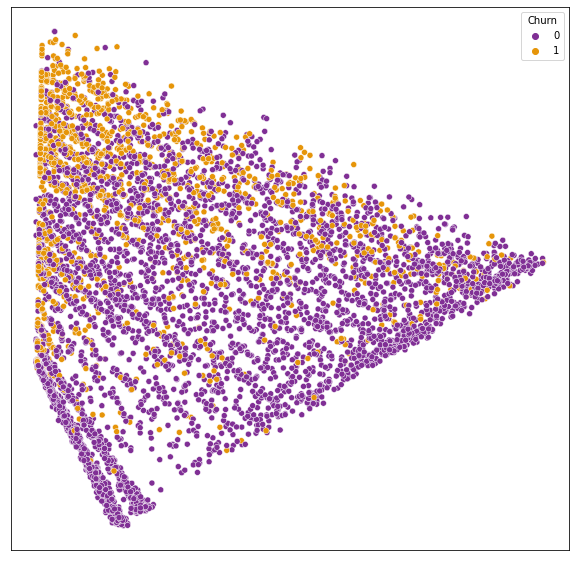

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=X_reduced[:, 0], 
    y=X_reduced[:, 1], 
    hue=df_w_y.astype(int), 
    palette="CMRmap",
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
#plt.title("MNIST data embedded into two dimensions by PCA", fontsize=18)
plt.show()

In [23]:
%%time
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(X_scaled)

C:\Users\Ermak\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Ermak\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: total: 1min 39s
Wall time: 28.7 s


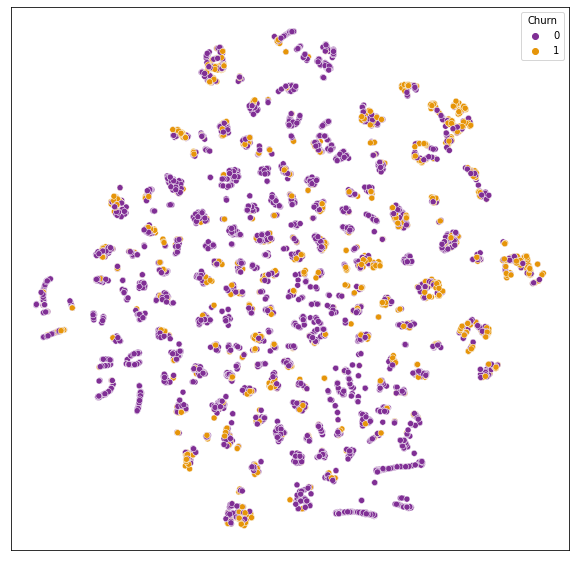

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0], 
    y=tsne_transformed[:, 1], 
    hue=df_w_y.astype(int), 
    palette="CMRmap",
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
#plt.title("MNIST data embedded into two dimensions by PCA", fontsize=18)
plt.show()

In [25]:
#!pip install umap-learn

In [27]:
%%time
import umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_scaled)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    hue=df_w_y.astype(int), 
    palette="CMRmap", 
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
#plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

CPU times: total: 28.3 s
Wall time: 28.3 s


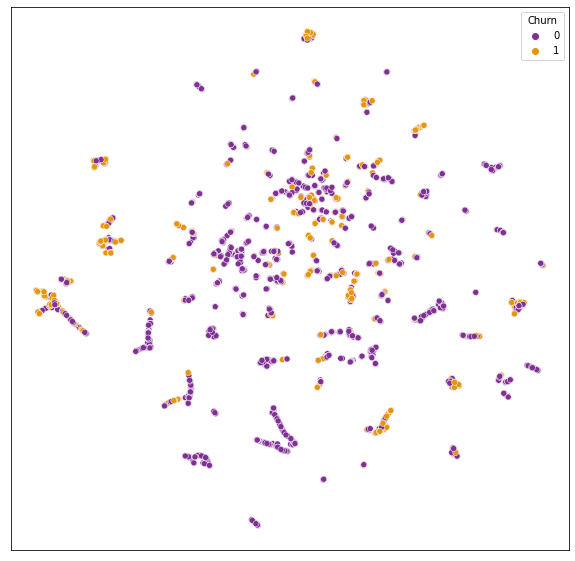

# Град буст

In [29]:
# ! pip install lightgbm
# ! pip install --upgrade catboost
# ! pip install --upgrade xgboost

In [30]:
from sklearn.model_selection  import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
X = df_w.drop(['customerID']+to_drop,axis = 1).iloc[:,:-1]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = df_w.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, shuffle = True)

In [32]:
weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = y_train.unique(), y = y_train)
weights = dict(zip(y_train.unique(),weights ))
weights

{1: 1.8842809364548494, 0: 0.6805991785455424}

In [33]:
s_weights = class_weight.compute_sample_weight(weights, y = y_train)
s_weights

array([1.88428094, 1.88428094, 0.68059918, ..., 1.88428094, 1.88428094,
       0.68059918])

## sklearn

In [34]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train,
                                                                                       sample_weight= s_weights)

      Iter       Train Loss   Remaining Time 
         1           1.2716            1.74s
         2           1.1893            1.61s
         3           1.1344            1.73s
         4           1.0952            1.66s
         5           1.0655            1.71s
         6           1.0407            1.67s
         7           1.0221            1.66s
         8           1.0070            1.66s
         9           0.9937            1.66s
        10           0.9839            1.65s
        20           0.9314            1.56s
        30           0.9089            1.49s
        40           0.8926            1.41s
        50           0.8778            1.33s
        60           0.8660            1.28s
        70           0.8535            1.20s
        80           0.8401            1.13s
        90           0.8247            1.14s
       100           0.8138            1.08s
       200           0.7113            0.34s
CPU times: total: 1.58 s
Wall time: 1.69 s


In [35]:

print('train ROC-AUC =',  roc_auc_score(y_train, gbm.predict(X_train)), 
      'test ROC-AUC =',  roc_auc_score(y_test, gbm.predict(X_test)))
print(classification_report(y_test, gbm.predict(X_test)))
confusion_matrix(y_test, gbm.predict(X_test))

train ROC-AUC = 0.8697019379246761 test ROC-AUC = 0.7645121289622568
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



array([[780, 255],
       [ 84, 290]], dtype=int64)

## CatBoostClassifier

In [36]:
from catboost import CatBoostClassifier 
clf_catboost = CatBoostClassifier(iterations=300,class_weights = weights)
clf_catboost.fit(X_train, y_train)

Learning rate set to 0.065015
0:	learn: 0.6713798	total: 145ms	remaining: 43.4s
1:	learn: 0.6469657	total: 155ms	remaining: 23s
2:	learn: 0.6244975	total: 161ms	remaining: 16s
3:	learn: 0.6070285	total: 171ms	remaining: 12.7s
4:	learn: 0.5913350	total: 174ms	remaining: 10.3s
5:	learn: 0.5782863	total: 177ms	remaining: 8.67s
6:	learn: 0.5663407	total: 180ms	remaining: 7.54s
7:	learn: 0.5544850	total: 186ms	remaining: 6.78s
8:	learn: 0.5454837	total: 189ms	remaining: 6.12s
9:	learn: 0.5376426	total: 192ms	remaining: 5.57s
10:	learn: 0.5302496	total: 195ms	remaining: 5.12s
11:	learn: 0.5233111	total: 199ms	remaining: 4.77s
12:	learn: 0.5203779	total: 201ms	remaining: 4.43s
13:	learn: 0.5144481	total: 203ms	remaining: 4.15s
14:	learn: 0.5093990	total: 206ms	remaining: 3.91s
15:	learn: 0.5051994	total: 209ms	remaining: 3.7s
16:	learn: 0.5008771	total: 211ms	remaining: 3.51s
17:	learn: 0.4978967	total: 214ms	remaining: 3.35s
18:	learn: 0.4952467	total: 217ms	remaining: 3.21s
19:	learn: 0.492

184:	learn: 0.3949558	total: 669ms	remaining: 416ms
185:	learn: 0.3945596	total: 673ms	remaining: 412ms
186:	learn: 0.3942384	total: 675ms	remaining: 408ms
187:	learn: 0.3939426	total: 677ms	remaining: 404ms
188:	learn: 0.3935443	total: 680ms	remaining: 399ms
189:	learn: 0.3933100	total: 683ms	remaining: 395ms
190:	learn: 0.3928266	total: 685ms	remaining: 391ms
191:	learn: 0.3926007	total: 688ms	remaining: 387ms
192:	learn: 0.3921945	total: 691ms	remaining: 383ms
193:	learn: 0.3917918	total: 693ms	remaining: 379ms
194:	learn: 0.3914411	total: 696ms	remaining: 375ms
195:	learn: 0.3910401	total: 698ms	remaining: 371ms
196:	learn: 0.3906809	total: 701ms	remaining: 366ms
197:	learn: 0.3901443	total: 704ms	remaining: 363ms
198:	learn: 0.3896554	total: 707ms	remaining: 359ms
199:	learn: 0.3891119	total: 710ms	remaining: 355ms
200:	learn: 0.3886685	total: 712ms	remaining: 351ms
201:	learn: 0.3883202	total: 716ms	remaining: 347ms
202:	learn: 0.3880593	total: 720ms	remaining: 344ms
203:	learn: 

In [38]:
print('train ROC-AUC =',  roc_auc_score(y_train, clf_catboost.predict(X_train)), 
      'test ROC-AUC =',  roc_auc_score(y_test, clf_catboost.predict(X_test)))
print(classification_report(y_test, clf_catboost.predict(X_test)))
confusion_matrix(y_test, clf_catboost.predict(X_test))

train ROC-AUC = 0.854333160143217 test ROC-AUC = 0.769376630757705
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1035
           1       0.53      0.79      0.64       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409



array([[779, 256],
       [ 80, 294]], dtype=int64)

## LGBMClassifier

In [39]:
from lightgbm import LGBMClassifier
clf_lightgbm = LGBMClassifier(n_estimators=300,class_weight = weights)
clf_lightgbm.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 0.6805991785455424, 1: 1.8842809364548494},
               n_estimators=300)

In [40]:
print('train ROC-AUC =',  roc_auc_score(y_train, clf_lightgbm.predict(X_train)), 
      'test ROC-AUC =',  roc_auc_score(y_test, clf_lightgbm.predict(X_test)))
print(classification_report(y_test, clf_lightgbm.predict(X_test)))
confusion_matrix(y_test, clf_lightgbm.predict(X_test))

train ROC-AUC = 0.9472284598496559 test ROC-AUC = 0.749413573070862
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.56      0.70      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



array([[829, 206],
       [113, 261]], dtype=int64)

## XGBClassifier

In [41]:
weights.values()

dict_values([1.8842809364548494, 0.6805991785455424])

In [42]:
from xgboost import XGBClassifier
clf_xgboost = XGBClassifier(n_estimators=300)
clf_xgboost.fit(X_train, y_train, sample_weight= s_weights ) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [43]:
print('train ROC-AUC =',  roc_auc_score(y_train, clf_xgboost.predict(X_train)), 
      'test ROC-AUC =',  roc_auc_score(y_test, clf_xgboost.predict(X_test)))
print(classification_report(y_test, clf_lightgbm.predict(X_test)))
confusion_matrix(y_test, clf_lightgbm.predict(X_test))

train ROC-AUC = 0.982177201770256 test ROC-AUC = 0.7265403394559405
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.56      0.70      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



array([[829, 206],
       [113, 261]], dtype=int64)

In [45]:
def boostings(df_w, scaled = True, lr = 0.1, iterations = 300, max_depth=3):
    X = df_w.drop(['customerID']+to_drop,axis = 1).iloc[:,:-1]
    if scaled:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

    y = df_w.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)
    
    weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = y_train.unique(), y = y_train)
    weights = dict(zip(y_train.unique(),weights ))
    s_weights = class_weight.compute_sample_weight(weights, y = y_train)
    gbm = GradientBoostingClassifier(n_estimators=iterations,
                                     learning_rate = lr,
                                     max_depth = max_depth,
                                    ).fit(X_train, y_train, sample_weight= s_weights)
     
    clf_catboost = CatBoostClassifier(iterations=iterations,
                                     learning_rate = lr,
                                     max_depth = max_depth,
                                    class_weights = weights
                                    ).fit(X_train, y_train)

    clf_lightgbm = LGBMClassifier(n_estimators=iterations,
                                     learning_rate = lr,
                                     max_depth = max_depth,
                                  class_weight = weights
                                    ).fit(X_train, y_train)

    clf_xgboost = XGBClassifier(n_estimators=iterations,
                                     learning_rate = lr,
                                     max_depth = max_depth,
                                    ).fit(X_train, y_train, sample_weight= s_weights )

    clear_output(True)
    
    print('GradientBoostingClassifier')
    print('train ROC-AUC =',  roc_auc_score(y_train, gbm.predict(X_train)), 
          'test ROC-AUC =',  roc_auc_score(y_test, gbm.predict(X_test)))
    
    print('CatBoostClassifier')      
    print('train ROC-AUC =',  roc_auc_score(y_train, clf_catboost.predict(X_train)), 
      'test ROC-AUC =',  roc_auc_score(y_test, clf_catboost.predict(X_test)))    
    
    print('LGBMClassifier')    
    print('train ROC-AUC =',  roc_auc_score(y_train, clf_lightgbm.predict(X_train)), 
      'test ROC-AUC =',  roc_auc_score(y_test, clf_lightgbm.predict(X_test)))
    
    print('XGBClassifier')
    print('train ROC-AUC =',  roc_auc_score(y_train, clf_xgboost.predict(X_train)), 
      'test ROC-AUC =',  roc_auc_score(y_test, clf_xgboost.predict(X_test)))

In [46]:
%%time
boostings(df_w, scaled = False)

GradientBoostingClassifier
train ROC-AUC = 0.841567163153978 test ROC-AUC = 0.7504805084088971
CatBoostClassifier
train ROC-AUC = 0.8057121224731549 test ROC-AUC = 0.7492107778552791
LGBMClassifier
train ROC-AUC = 0.8217956933031988 test ROC-AUC = 0.7449417448138677
XGBClassifier
train ROC-AUC = 0.8229108706560727 test ROC-AUC = 0.7386279676561007
CPU times: total: 6.27 s
Wall time: 3.18 s


In [47]:
%%time
boostings(df_w)

GradientBoostingClassifier
train ROC-AUC = 0.8360492937317837 test ROC-AUC = 0.7505476762510012
CatBoostClassifier
train ROC-AUC = 0.804020892707511 test ROC-AUC = 0.7648376346586065
LGBMClassifier
train ROC-AUC = 0.8172521596915223 test ROC-AUC = 0.7611640703712316
XGBClassifier
train ROC-AUC = 0.8231524749083076 test ROC-AUC = 0.7622426309127076
CPU times: total: 5.98 s
Wall time: 3.32 s


In [48]:
%%time
boostings(df_w, scaled = True, lr = 0.1, iterations = 100, max_depth=1)

GradientBoostingClassifier
train ROC-AUC = 0.7657767172688862 test ROC-AUC = 0.7559843963936036
CatBoostClassifier
train ROC-AUC = 0.7647823420421297 test ROC-AUC = 0.7599950915807693
LGBMClassifier
train ROC-AUC = 0.765516124053683 test ROC-AUC = 0.7585458162184505
XGBClassifier
train ROC-AUC = 0.7642152588842086 test ROC-AUC = 0.7590289080058901
CPU times: total: 1.38 s
Wall time: 567 ms


In [49]:
%%time
boostings(df_w, scaled = True, lr = 0.1, iterations = 1000, max_depth=1)

GradientBoostingClassifier
train ROC-AUC = 0.7800213484426222 test ROC-AUC = 0.75934408018807
CatBoostClassifier
train ROC-AUC = 0.7782931912043123 test ROC-AUC = 0.7619055000129169
LGBMClassifier
train ROC-AUC = 0.7768804931635692 test ROC-AUC = 0.7583778966131908
XGBClassifier
train ROC-AUC = 0.7802070362592227 test ROC-AUC = 0.7583778966131908
CPU times: total: 9.56 s
Wall time: 5.02 s


In [50]:
%%time
boostings(df_w, scaled = True, lr = 0.1, iterations = 1000, max_depth=3)

GradientBoostingClassifier
train ROC-AUC = 0.9145891798464885 test ROC-AUC = 0.730842956418404
CatBoostClassifier
train ROC-AUC = 0.8475793112420317 test ROC-AUC = 0.7421219871347748
LGBMClassifier
train ROC-AUC = 0.8779613287749048 test ROC-AUC = 0.7371451083727298
XGBClassifier
train ROC-AUC = 0.8876803648466622 test ROC-AUC = 0.7386731767805937
CPU times: total: 18.7 s
Wall time: 10.6 s


In [51]:
%%time
boostings(df_w, scaled = True, lr = 0.1, iterations = 1000, max_depth=4)

GradientBoostingClassifier
train ROC-AUC = 0.9768249807484237 test ROC-AUC = 0.7057118499573743
CatBoostClassifier
train ROC-AUC = 0.9021375916015454 test ROC-AUC = 0.7297979797979797
LGBMClassifier
train ROC-AUC = 0.9362555057892097 test ROC-AUC = 0.7178782712030793
XGBClassifier
train ROC-AUC = 0.9402978923867188 test ROC-AUC = 0.7166201658529024
CPU times: total: 24 s
Wall time: 13.3 s


In [52]:
%%time
boostings(df_w, scaled = True, lr = 0.1, iterations = 10000, max_depth=1)

GradientBoostingClassifier
train ROC-AUC = 0.7947391684127086 test ROC-AUC = 0.764433335916712
CatBoostClassifier
train ROC-AUC = 0.7854384551549379 test ROC-AUC = 0.7668823787749618
LGBMClassifier
train ROC-AUC = 0.7864607885995114 test ROC-AUC = 0.7619055000129169
XGBClassifier
train ROC-AUC = 0.7936150218049858 test ROC-AUC = 0.7669947557415588
CPU times: total: 1min 34s
Wall time: 50.6 s


In [53]:
%%time
boostings(df_w, scaled = True, lr = 0.4, iterations = 500, max_depth=1)

GradientBoostingClassifier
train ROC-AUC = 0.7771041589061065 test ROC-AUC = 0.7856777493606137
CatBoostClassifier
train ROC-AUC = 0.7747160746015752 test ROC-AUC = 0.7850822806065773
LGBMClassifier
train ROC-AUC = 0.7746791471289092 test ROC-AUC = 0.7859360872148595
XGBClassifier
train ROC-AUC = 0.7763513879315848 test ROC-AUC = 0.7870146477563357
CPU times: total: 5.14 s
Wall time: 2.51 s


In [54]:
%%time
boostings(df_w, scaled = True, lr = 0.1, iterations = 500, max_depth=10)

GradientBoostingClassifier
train ROC-AUC = 0.9979743220738209 test ROC-AUC = 0.6811310031258879
CatBoostClassifier
train ROC-AUC = 0.9866189222187834 test ROC-AUC = 0.700993309049575
LGBMClassifier
train ROC-AUC = 0.9691585303673921 test ROC-AUC = 0.6866801002350873
XGBClassifier
train ROC-AUC = 0.9932350809374245 test ROC-AUC = 0.6804903252473585
CPU times: total: 39.8 s
Wall time: 21.8 s
